# **Tomato Leaf Disease Classification**

### **Import required packages**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
# constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
FILE_PATH = "PlantVillage"

In [3]:
# copying only the necessary datasets
!mkdir "PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Bacterial_spot/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Early_blight/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Late_blight/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Leaf_Mold/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato__Target_Spot/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato__Tomato_mosaic_virus/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_healthy/" "/kaggle/working/PlantVillage"

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=FILE_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 14240 files belonging to 9 classes.


2022-10-11 22:37:55.159987: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

### **Data Visualization**

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

2022-10-11 22:37:55.396798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 256, 256, 3)
[5 2 0 0 0 2 1 3 4 0 4 0 0 2 6 8 3 8 7 0 0 4 2 2 3 6 4 6 0 2 6 1]


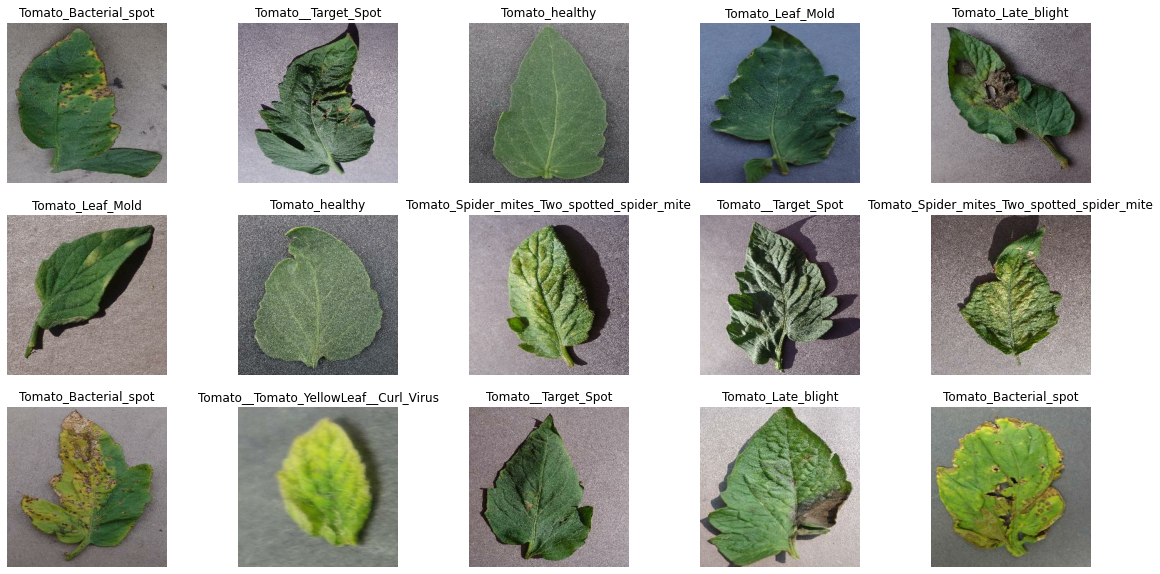

In [7]:
plt.figure(figsize=(20, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### **Train Test Split**

In [8]:
def get_dataset_partitions(
    ds,
    train_split=0.8,
    test_split=0.1,
    valid_split=0.1,
    shuffle=True,
    shuffle_size=10000,
):
    assert train_split + test_split + valid_split == 1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
    train_size = int(len(ds) * train_split)
    valid_size = int(len(ds) * valid_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds, test_ds, valid_ds

In [9]:
train_ds, test_ds, valid_ds = get_dataset_partitions(dataset)

In [10]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

356
45
44


In [11]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Image Preprocessing**

In [12]:
rescale_and_resize = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(
            IMAGE_SIZE, IMAGE_SIZE
        ),  # will resize to the IMAGE_SIZE if there's any issue
        layers.experimental.preprocessing.Rescaling(1.0 / 255),  # Normalization
    ]
)

In [13]:
# data augmentation

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

### **Building a Model**

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential(
    [
        rescale_and_resize,
        data_augmentation,
        layers.Conv2D(
            32, kernel_size=(3, 3), activation="relu", input_shape=input_shape
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax"),
    ]
)

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [17]:
EPOCHS = 10

In [18]:
if "history" not in locals():
    history = []
# model training
history.append(
    model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS,
    )
)

Epoch 1/10
356/356 [==============================] - 500s 1s/step - loss: 1.5157 - accuracy: 0.4543 - val_loss: 1.4597 - val_accuracy: 0.5298
Epoch 2/10
356/356 [==============================] - 482s 1s/step - loss: 0.8477 - accuracy: 0.7029 - val_loss: 0.8204 - val_accuracy: 0.7337
Epoch 3/10
356/356 [==============================] - 483s 1s/step - loss: 0.5491 - accuracy: 0.8042 - val_loss: 1.2022 - val_accuracy: 0.6229
Epoch 4/10
356/356 [==============================] - 479s 1s/step - loss: 0.4350 - accuracy: 0.8466 - val_loss: 0.7474 - val_accuracy: 0.7756
Epoch 5/10
356/356 [==============================] - 482s 1s/step - loss: 0.3692 - accuracy: 0.8705 - val_loss: 0.5908 - val_accuracy: 0.8232
Epoch 6/10
356/356 [==============================] - 479s 1s/step - loss: 0.3284 - accuracy: 0.8863 - val_loss: 0.5973 - val_accuracy: 0.8061
Epoch 7/10
356/356 [==============================] - 480s 1s/step - loss: 0.3054 - accuracy: 0.8940 - val_loss: 1.1534 - val_accuracy: 0.7195

In [19]:
scores = model.evaluate(test_ds)
scores

45/45 [==============================] - 20s 297ms/step - loss: 0.3628 - accuracy: 0.8764


[0.36276981234550476, 0.8763889074325562]

### **Plotting Model Accuracy**

In [20]:
acc = []
val_acc = []
loss = []
val_loss = []

for h in history:
    acc.extend(h.history["accuracy"])
    val_acc.extend(h.history["val_accuracy"])
    loss.extend(h.history["loss"])
    val_loss.extend(h.history["val_loss"])

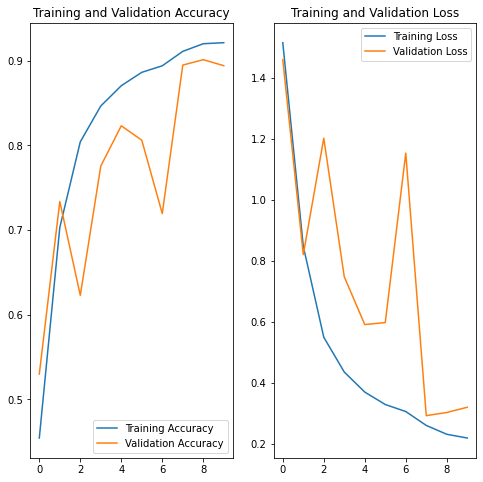

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

### **Running prediction on a sample image**

first image to predict
actual label: Tomato_Late_blight
predicted label: Tomato_Late_blight


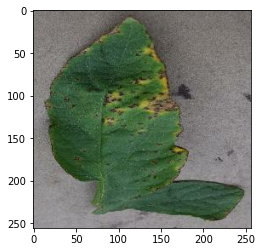

In [22]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    break

### **Predictions**

In [23]:
def predict_tomato_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

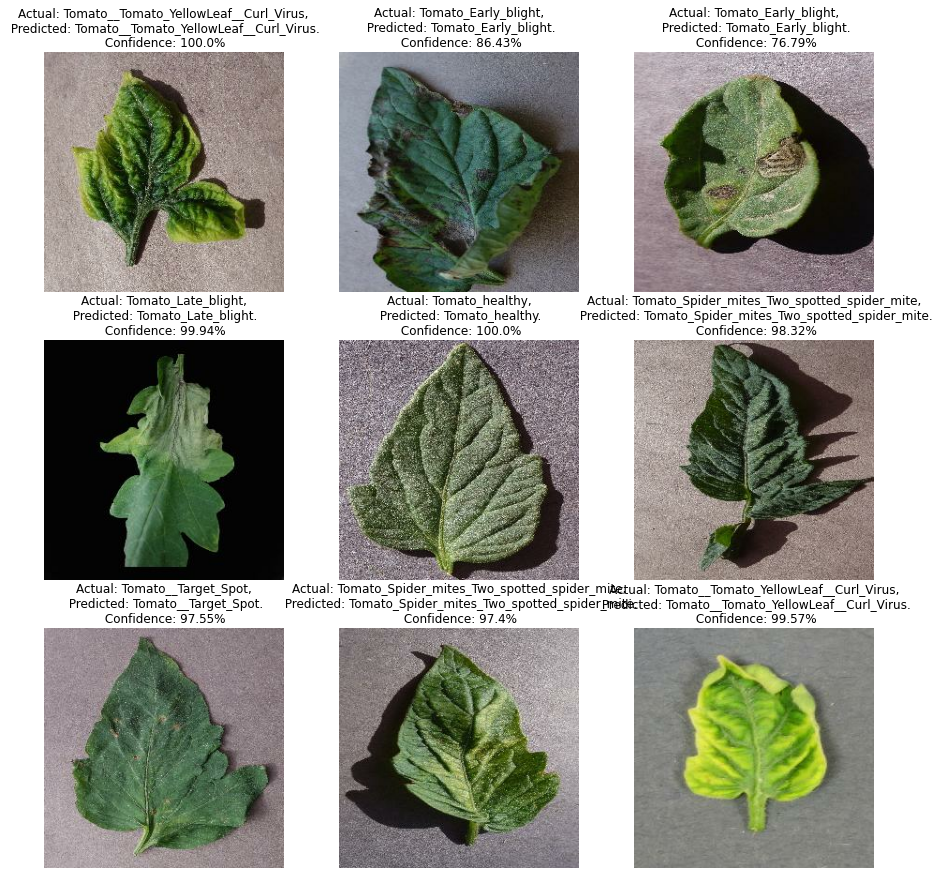

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict_tomato_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(
            f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%"
        )

        plt.axis("off")